# Titanic Survival

![Titanic](https://steemitimages.com/DQmXBSD8r18J5tNvRBJPRvsLGCNU4L7TXukFYPf6Rpa4m8v/10080_096_02.jpg)

## 1. Importing libraries and dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

print('Done !')

Done !


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print('train_data shape : ',train_data.shape)
print('test_data shape : ',test_data.shape)

train_data.head()

train_data shape :  (891, 12)
test_data shape :  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<mark>Survived</mark> is the **target** column and the rest are **input** features.

In [3]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


___

## 2. Data Pre-Processing

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


- Age has **177** missing values.
- Cabin has **687** missing values.
- Embarked has **2** missing values.

* Therefore I will <mark>drop</mark> **Cabin** from both train_data n test_data.
* Also I think **Names**, **Ticket** and **Embarked** will not be useful features for predicting survival.

In [5]:
train_data = train_data.drop(columns = ['Cabin', 'Name', 'Embarked', 'Ticket'])
test_data = test_data.drop(columns = ['Cabin', 'Name', 'Ticket', 'Embarked'])

##### Label encoding **Sex**. 

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_data.Sex = le.fit_transform(train_data.Sex)
test_data.Sex = le.transform(test_data.Sex)

train_data.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1,0,7.2500
1,2,1,1,0,38.0,1,0,71.2833
2,3,1,3,0,26.0,0,0,7.9250


**Males : 1     
Females : 0**

##### Data imputation

In [7]:
train_data = train_data.fillna(train_data['Age'].mean())

___

## 3. Feature Engineering

##### Making a new feature **Age_Category** using the **Age** feature according the following rule : 

- 0 : Age less than 16
- 1 : Age less than 36
- 2 : Age less than 51
- 3 : Age greater than 50

In [8]:
def ageCategory(df):
    age_category = []
    
    for ix in range(df.shape[0]):
        age = df.Age.loc[ix]
        
        if age <= 15.0:
            age_category.append(0)
        elif age <= 35.0:
            age_category.append(1)
        elif age <= 55.0:
            age_category.append(2)
        else :
            age_category.append(3)
            
    df['Age_Category'] = age_category

In [9]:
ageCategory(train_data)
ageCategory(test_data)

train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_Category
0,1,0,3,1,22.0,1,0,7.2500,1
1,2,1,1,0,38.0,1,0,71.2833,2
2,3,1,3,0,26.0,0,0,7.9250,1
3,4,1,1,0,35.0,1,0,53.1000,1
4,5,0,3,1,35.0,0,0,8.0500,1


##### Also let's combine **SibSp** and **Parch** to make a single feature **Family_Size**

In [10]:
def famSize(df):
    family_size = []
    
    for ix in range(df.shape[0]):
        sibsp = df.SibSp.loc[ix]
        parch = df.Parch.loc[ix]
        
        family_size.append(sibsp + parch + 1)
    
    df['Family_Size'] = family_size

In [11]:
famSize(train_data)
famSize(test_data)

train_data.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_Category,Family_Size
0,1,0,3,1,22.0,1,0,7.2500,1,2
1,2,1,1,0,38.0,1,0,71.2833,2,2
2,3,1,3,0,26.0,0,0,7.9250,1,1


___

## 4. Exploratory Data Analysis

![EDA](TItanic-Survival-Infographic.jpg)

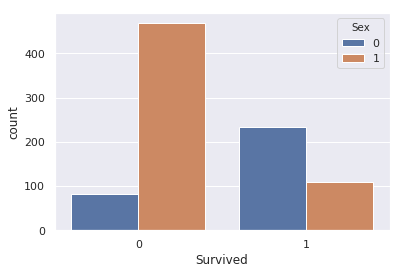

In [12]:
sns.countplot(x = "Survived", hue = "Sex", data = train_data)
plt.show()

<mark> Chances for **females** surviving the titanic is **more** than **males**. </mark>

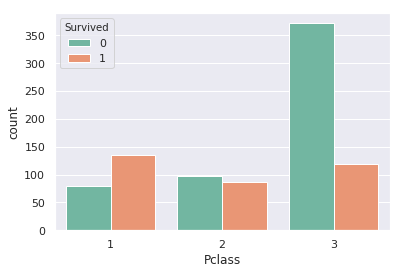

In [13]:
sns.countplot(x = "Pclass", hue = "Survived", data = train_data, palette = sns.color_palette("Set2"))
plt.show()

<mark> Passengers from **First class** have a **high** chance of survival and passengers from **Third class** have a **very less** chance of surviving from the **Titanic** </mark>

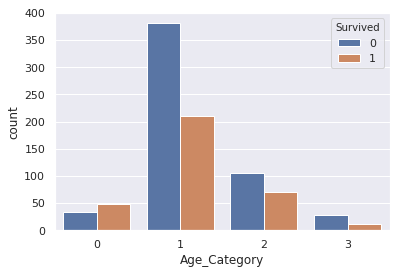

In [14]:
sns.countplot(x = "Age_Category", hue = "Survived", data = train_data)
plt.show()

<mark> Kids below the age of **15** have a **greater probability** of surviving than any other age group </mark>

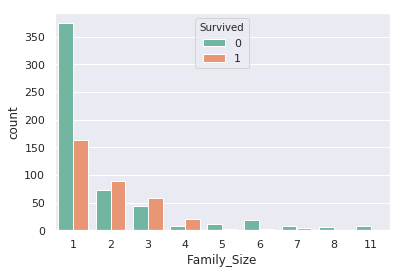

In [15]:
sns.countplot(x = "Family_Size", hue = "Survived", data = train_data, palette = sns.color_palette("Set2"))
plt.show()

<mark> **Single** passengers (family size = 1) had a **very low** chance of surviving and passengers with a family size of **2, 3, 4** have a **high** chance of surviving the Titanic </mark>

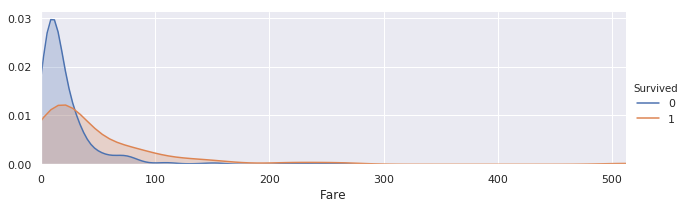

In [16]:
facet = sns.FacetGrid(train_data, hue = "Survived",aspect = 3)
facet.map(sns.kdeplot, 'Fare' , shade = True)
facet.set(xlim = (0, train_data['Fare'].max()))
facet.add_legend()
plt.show()

<mark> After a certain fare the probability of survival increases </mark>

##### Conclusion :
**Sex, Pclass, Age_Category, Family_Size, Fare** are <mark>good</mark> features for predicting the survival 

## 5. Implementing Decission Tree Model

In [17]:
# Entropy of a given feature

def entropy(col):
    counts = np.unique(col, return_counts = True)
    
    e = 0.0
    total_no_of_samples = col.shape[0]
    
    for freq in counts[1]:
        p = freq / total_no_of_samples
        e += ((-1 * p) * np.log2(p))
        
    return e

In [18]:
# Dividing Data at each Node

def divide(x_data, fkey, fval):
    left = pd.DataFrame([], columns = x_data.columns)
    right = pd.DataFrame([], columns = x_data.columns)
    
    for i in range(x_data.shape[0]):
        val = x_data[fkey].loc[i]
        
        if val > fval:
            right = right.append(x_data.loc[i])
        else:
            left = left.append(x_data.loc[i])
    
    return left, right

In [19]:
# Calculating Information Gain

def informationGain(x_data, fkey, fval):
    
    left, right = divide(x_data, fkey, fval)
    N = x_data.shape[0]
    
    # Ratio of samples in left, right
    l = float(left.shape[0] / N)
    r = float(right.shape[0] / N)
    
    i_gain = entropy(x_data['Survived']) - ((l * entropy(left['Survived'])) + (r * entropy(right['Survived'])))
    
    return i_gain

In [20]:
class DecisionTree:
    
    #constructor
    def __init__(self, depth = 0, max_depth = 4):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.max_depth = max_depth
        self.depth = depth
        self.target = None
        
    def train(self, train_data):
        features = ['Pclass', 'Sex', 'Family_Size', 'Fare', 'Age_Category']
        info_gains = []
        for i in features:
            i_gain = informationGain(train_data, i, train_data[i].mean())
            info_gains.append(i_gain)
        
        self.fkey = features[np.argmax(info_gains)]
        self.fval = train_data[self.fkey].mean()
        
        # print("Making tree feature is", self.fkey)
        
        data_left, data_right = divide(train_data, self.fkey, self.fval)
        data_left = data_left.reset_index(drop = True)
        data_right = data_right.reset_index(drop = True)
        
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:
            if train_data.Survived.mean() >= 0.5:
                self.target = 1 # survived
            else:
                self.target = 0 # dead
            return
        
        if self.depth >= self.max_depth:
            if train_data.Survived.mean() >= 0.5:
                self.target = 1
            else:
                self.target = 0
            return
        
        self.left = DecisionTree(depth = self.depth + 1, max_depth = self.max_depth)
        self.left.train(data_left)
        
        self.right = DecisionTree(depth = self.depth + 1, max_depth = self.max_depth)
        self.right.train(data_right)
        
        if train_data.Survived.mean() >= 0.5:
            self.target = 1
        else:
            self.target = 0
        return
    
    def predict(self,test):
        if test[self.fkey]>self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            if self.left is None:
                return self.target
            return self.left.predict(test)

## 4. Train-Validation set

In [21]:
split = int(0.7 * train_data.shape[0])

trainData = train_data[: split]
valData = train_data[split:]

valData = valData.reset_index(drop = True)

In [22]:
dt = DecisionTree()

dt.train(trainData)

In [23]:
y_pred = []

for ix in range(valData.shape[0]):
    y_pred.append(dt.predict(valData.loc[ix]))

In [24]:
y_actual = valData['Survived']

In [25]:
print('Accuracy = ', (np.sum(y_pred == y_actual) / y_actual.shape)[0])

Accuracy =  0.8134328358208955


#### Accuracy on validation set is 81.34 %

## Testing the model on test dataset

#### Prepairing the test dataset

In [26]:
test_data.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Age_Category,Family_Size
0,892,3,1,34.5,0,0,7.8292,1,1
1,893,3,0,47.0,1,0,7.0000,2,2
2,894,2,1,62.0,0,0,9.6875,3,1
3,895,3,1,27.0,0,0,8.6625,1,1
4,896,3,0,22.0,1,1,12.2875,1,3


In [27]:
y_pred_test = []
pid = []

for ix in range(test_data.shape[0]):
    pid.append(int(test_data.loc[ix]['PassengerId']))
    y_pred_test.append(dt.predict(test_data.loc[ix]))

In [28]:
y_pred_test[:10]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0]

In [29]:
pid[:10]

[892, 893, 894, 895, 896, 897, 898, 899, 900, 901]

In [30]:
df = pd.DataFrame({
    'PassengerId' : pid,
    'Survived' : y_pred_test
})

df.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [31]:
df.to_csv('prediction.csv', index = False)

#### The test score was 77.99% on Kaggle